## 사진에서 사람영역만 구분 (배경지우기)

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

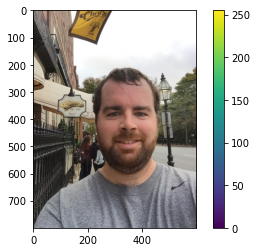

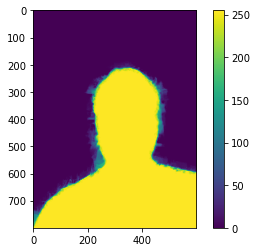

In [8]:
import glob
import imageio
x = imageio.imread('./dataset/training/00002.png')
y = imageio.imread('./dataset/training/00002_matte.png')
plt.imshow(x)
plt.colorbar()
plt.show()

plt.imshow(y)
plt.colorbar()
plt.show()

In [9]:
# x와 y를 각각 (800, 600, 3) -> (100, 75, 3), (800, 600) -> (100, 75)로 줄이고 plt에서 확인하는 코드를 작성하세요.
from skimage.transform import resize
x1 = resize(x, (100, 75))
y1 = resize(y, (100, 75))

In [10]:
x1.shape

(100, 75, 3)

In [11]:
y1.shape

(100, 75)

In [13]:
pfcn_small = np.load('./pfcn_small.npz')

In [14]:
train_images = pfcn_small['train_images']
train_mattes = pfcn_small['train_mattes']
test_images = pfcn_small['test_images']
test_mattes = pfcn_small['test_mattes']

In [15]:
train_images.dtype

dtype('float64')

In [17]:
print(train_images.shape)

(1700, 100, 75, 3)


## 전처리

In [16]:
print(train_images.max(), train_images.min())
print(test_images.max(), test_images.min())

1.0 0.0
1.0 0.0


In [19]:
from skimage import color

train_mattes = np.array( [color.rgb2gray(img).reshape((100, 75, 1)) for img in train_mattes] )
test_mattes = np.array( [color.rgb2gray(img).reshape((100, 75, 1)) for img in test_mattes] )
train_mattes.shape, test_mattes.shape

((1700, 100, 75, 1), (300, 100, 75, 1))

In [20]:
train_images[:5].shape

(5, 100, 75, 3)

- (5, 100, 75, 3)
- (100, 5, 75, 3)
- (100, 5*75, 3)
- (100, 375, 3)

In [21]:
train_images[:5].transpose([1, 0, 2, 3]).reshape((100, -1 ,3)).shape

(100, 375, 3)

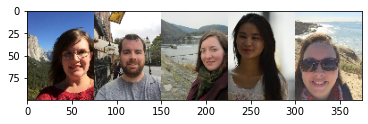

In [22]:
plt.imshow(train_images[:5].transpose([1, 0, 2, 3]).reshape((100, -1 ,3)))
plt.show()

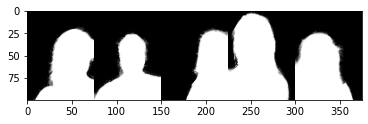

In [24]:
plt.imshow(train_mattes[:5].transpose([1, 0, 2, 3]).reshape((100, -1)), cmap="gray")
plt.show()

In [27]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, UpSampling2D, Flatten, Reshape
from keras.models import Model

def ae_like():
    
    inputs = Input((100, 75, 3))
    x = Conv2D(32, 3, 2, activation='relu', padding='same')(inputs)
    x = Conv2D(64, 3, 2, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, 2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    latent = Dense(10)(x)

    x = Dense((13 * 10 * 128))(latent)
    x = Reshape((13, 10, 128))(x)

    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(128, (2,2), (1,1), activation='relu', padding='valid')(x)

    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(64, (1,1), (1,1), activation='relu', padding='valid')(x)

    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(32, (1,2), (1,1), activation='relu', padding='valid')(x)

    x = Conv2D(1, (1,1), (1,1), activation='sigmoid')(x)


    model = Model(inputs, x)
    return model

In [28]:
model = ae_like()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 75, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 38, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 19, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 10, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 16640)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                166410    
_________________________________________________________________
dense_1 (Dense)              (None, 16640)             183040

In [29]:
from keras.layers import Dense, Input, Conv2D, UpSampling2D, Flatten, Reshape
from keras.models import Model

def ae_like():
    inputs = Input((100, 75, 3))
    x = Conv2D(32, 3, 2, activation='relu', padding='same')(inputs)
    x = Conv2D(64, 3, 2, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, 2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    latent = Dense(10)(x)
    
    x = Dense((13 * 10 * 128))(latent)
    x = Reshape((13, 10, 128))(x)
    
    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(128, (2,2), (1,1), activation='relu', padding='valid')(x)
    
    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(64, (1,1), (1,1), activation='relu', padding='valid')(x)
    
    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(32, (1,2), (1,1), activation='relu', padding='valid')(x)
    
    x = Conv2D(1, (1,1), (1,1), activation='relu', padding='valid')(x)
    
    model = Model(inputs, x)
    return model

In [30]:
model = ae_like()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 75, 3)]      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 38, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 19, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 10, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 16640)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                166410    
_________________________________________________________________
dense_3 (Dense)              (None, 16640)             1830

In [31]:
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [32]:
hist = model.fit(train_images, train_mattes, validation_data=(test_images, test_mattes), epochs=25, verbose=1)

Epoch 1/25
54/54 [==============================] - 9s 76ms/step - loss: 0.3083 - accuracy: 0.5536 - val_loss: 0.1347 - val_accuracy: 0.7560
Epoch 2/25
54/54 [==============================] - 1s 13ms/step - loss: 0.1320 - accuracy: 0.7587 - val_loss: 0.1221 - val_accuracy: 0.7634
Epoch 3/25
54/54 [==============================] - 1s 12ms/step - loss: 0.1224 - accuracy: 0.7667 - val_loss: 0.1195 - val_accuracy: 0.7667
Epoch 4/25
54/54 [==============================] - 1s 12ms/step - loss: 0.1225 - accuracy: 0.7661 - val_loss: 0.1180 - val_accuracy: 0.7703
Epoch 5/25
54/54 [==============================] - 1s 12ms/step - loss: 0.1178 - accuracy: 0.7733 - val_loss: 0.1117 - val_accuracy: 0.7797
Epoch 6/25
54/54 [==============================] - 1s 12ms/step - loss: 0.1060 - accuracy: 0.7918 - val_loss: 0.0978 - val_accuracy: 0.8029
Epoch 7/25
54/54 [==============================] - 1s 12ms/step - loss: 0.0924 - accuracy: 0.8110 - val_loss: 0.0985 - val_accuracy: 0.8018
Epoch 8/25
54

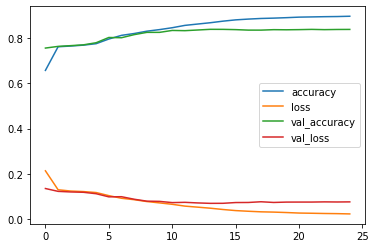

In [39]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label = "accuracy")
plt.plot(hist.history['loss'], label = "loss")
plt.plot(hist.history['val_accuracy'], label = "val_accuracy")
plt.plot(hist.history['val_loss'], label = "val_loss")
plt.legend(loc = "center right")
plt.show()

## 결과확인

In [41]:
res = model.predict( test_images[0:1] )

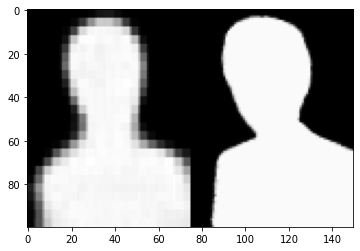

In [46]:
plt.imshow(np.concatenate([res[0], test_mattes[0]]).reshape((2, -1, 75, 1)).transpose([1, 0, 2, 3]).reshape((100, -1)),cmap = "gray")

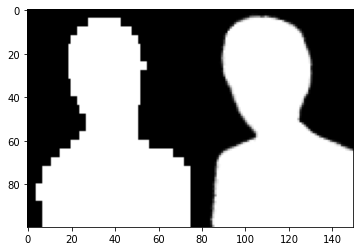

In [48]:
plt.imshow(np.concatenate([(res[0]>0.5).astype(np.float64), test_mattes[0]]).reshape((2, -1, 75, 1)).transpose([1, 0, 2, 3]).reshape((100, -1)),cmap = "gray")

In [51]:
five = (model.predict(test_images[:5]) > 0.5).astype(np.float64)

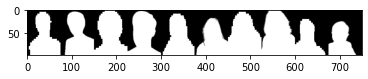

In [53]:
plt.imshow(np.concatenate([five, test_mattes[:5]], axis =2).transpose([1, 0, 2, 3]).reshape((100, -1)),cmap = "gray")
plt.show()

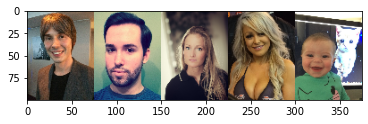

In [55]:
plt.imshow(test_images[:5].transpose((1, 0, 2, 3)).reshape((100, -1, 3))) 
plt.show()

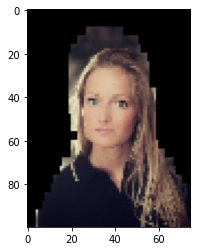

In [56]:
plt.imshow(five[2].reshape((100, 75, 1))*test_images[2])

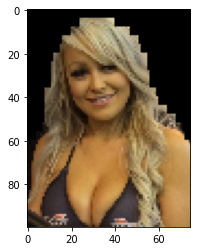

In [57]:
plt.imshow(five[3].reshape((100, 75, 1))*test_images[3])

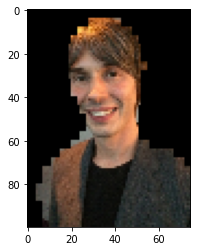

In [58]:
plt.imshow(five[0].reshape((100, 75, 1))*test_images[0])

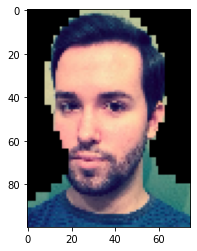

In [59]:
plt.imshow(five[1].reshape((100, 75, 1))*test_images[1])